In [2]:
import gym
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

In [3]:
class Fourier_Basis:
  def __init__(self, order, k):
    #self.env = env
    self.order = [order]*k
    self.coefficients = np.array([])

  def get_coefficients(self):
    prods = [range(0, i+1) for i in self.order]
    #print(prods)
    coeffs = [v for v in itertools.product(*prods)]
    self.coefficients = np.array(coeffs)
    return self.coefficients
  
  def value(self, state):
    self.get_coefficients()
    return np.cos(np.pi*np.dot(self.coefficients, state))
  

class Expected_SARSA:
  def __init__(self, env, gamma, order, k):
    self.state_num = env.observation_space.shape[0]
    self.action_num = env.action_space.n
    self.w = np.random.uniform(-0.001, 0.001, ((order + 1)**k, self.action_num))
    self.gamma = gamma

  #define the greedy policy
  def policy(self, states, epsilon):
    if random.uniform(0, 1) < epsilon:
        return np.random.randint(self.action_num)
    else:
        return states.argmax()

  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def update(self, current, target, reward, state, action, alpha, done):
    error = reward + self.gamma * target* (not done) - current
    #print(error)
    self.w[:, action] += alpha * error * state

def Expected_SARSA_implement(env, alpha, epsilon, order, k, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    Expected_SAR = Expected_SARSA(env, gamma, order, k)
    FB = Fourier_Basis(order, k)
    u_state = np.array([env.observation_space.high[0], 10, env.observation_space.high[2], 5])
    l_state = np.array([env.observation_space.low[0], -10, env.observation_space.low[2], -5])
    d_state = u_state - l_state
    #print(d_state)


    rewards = []
    for i in range(episodes):
      s = env.reset()
      reward_ep = 0
      done = False
      state_encoding = (env.reset() - l_state) / d_state
      #print(state_encoding)
      state_cos = FB.value(state_encoding)
      state_value = Expected_SAR.apply_weight(state_cos)
      while not done:
        a = Expected_SAR.policy(state_value, epsilon)
        v_i = state_value[a]
        s, reward, done, _ = env.step(a)
        next_state = (s - l_state) / d_state
        next_state_cos = FB.value(next_state)
        v_next = epsilon * np.mean(Expected_SAR.apply_weight(next_state_cos)) + (1 - epsilon) * np.max(Expected_SAR.apply_weight(next_state_cos))
        Expected_SAR.update(v_i, v_next, reward, state_cos, a, alpha, done)
        state_encoding = next_state
        state_cos = FB.value(state_encoding)
        state_value = Expected_SAR.apply_weight(state_cos)
        reward_ep += reward
      rewards.append(reward_ep)
    trial_reward.append(rewards)

  return trial_reward

In [24]:
env = gym.make("CartPole-v1")
obs = env.reset()

#define the parameters
epsilon = [0.1, 0.01]
order = 5
k = env.observation_space.shape[0]
alpha = [1e-3, 5e-4, 1e-4]
trials = 30
gamma = 0.99
episodes = 500

In [25]:
CP_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for i in range(len(epsilon)):
    avg_return = Expected_SARSA_implement(env, alpha[j], epsilon[i], order, k, gamma)
    learning_return_SARSA.append(avg_return)
  CP_epsilon_return_SARSA.append(learning_return_SARSA)

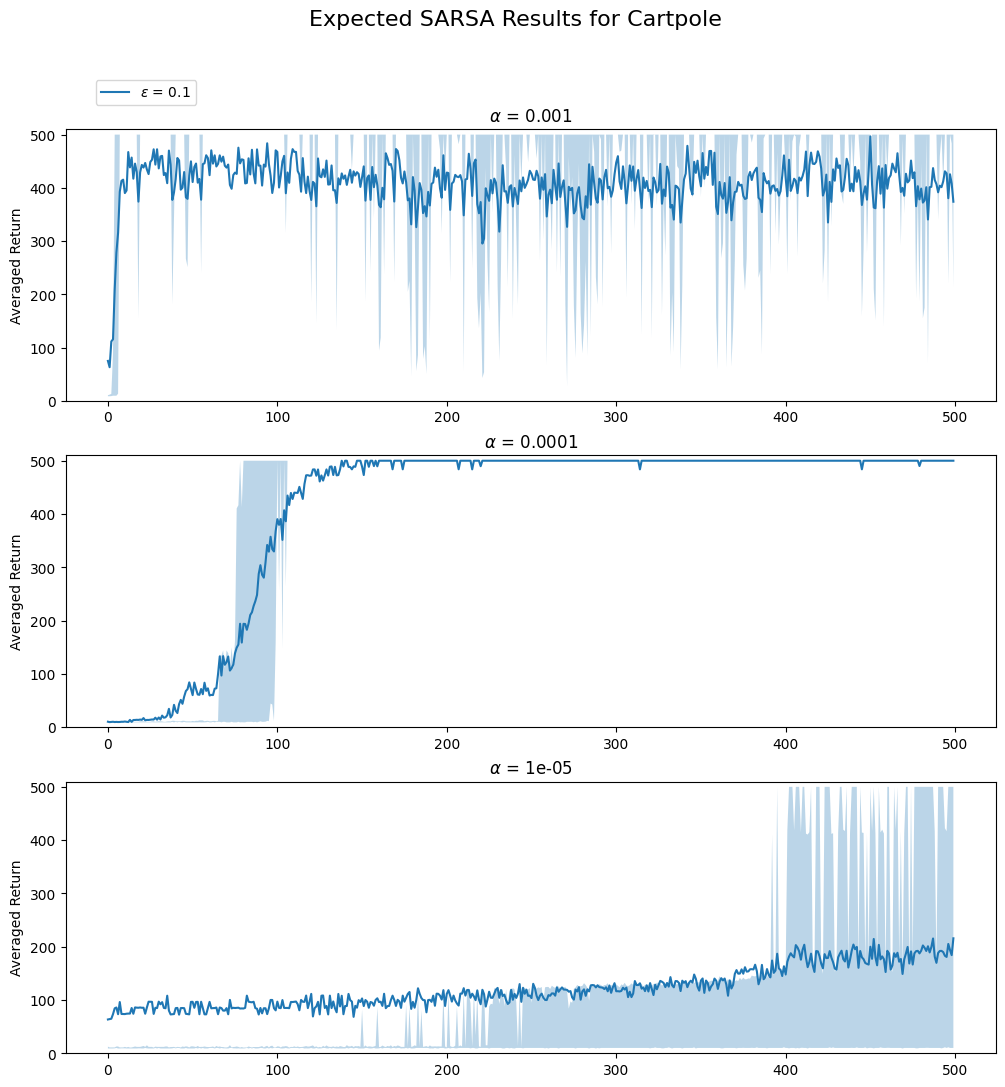

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(CP_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylim=[0, 510], ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for Cartpole', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)